# Excitation-Inhibition Range II
Now calculated with better ranges

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'efa0a27d18c333fb9be5ffaf957cadd91cd66505'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from analysis_functions import calculate_recall_success_sequences
from connectivity_functions import create_artificial_manager 
from analysis_functions import calculate_excitation_inhibition_ratio, calculate_excitation, calculate_inhibition
from analysis_functions import calculate_recall_time_quantities

In [4]:
def calculate_excitation_inhibition_ratio_artificial(value, inhibition, hypercolumns, minicolumns, n_patterns):
    
    excitation_normal = value * hypercolumns + value * (hypercolumns - 1)
    inhibition_normal = -1 * inhibition * hypercolumns * (minicolumns - 2)
    normal = ((n_patterns - 1.0) / n_patterns) * (excitation_normal / inhibition_normal)
    
    excitation_first = value * (hypercolumns - 1)
    inhibition_first = -1 * inhibition * hypercolumns * (minicolumns - 1)
    first = (1.0 / n_patterns) * (excitation_first / inhibition_first)
    
    return normal + first

def excitation_from_value(value, hypercolumns, minicolumns, n_patterns):
    excitation_normal = value * hypercolumns + value * (hypercolumns - 1)
    normal = ((n_patterns - 1.0) / n_patterns) * (excitation_normal)
    
    excitation_first =  excitation_first = value * (hypercolumns - 1)
    first = (1.0 / n_patterns) * (excitation_first)
    
    excitation_total = normal + first
    
    return excitation_total

def inhibition_from_value(inhibition, hypercolumns, minicolumns, n_patterns):
    inhibition_normal = -1 * inhibition * hypercolumns * (minicolumns - 2)
    normal = ((n_patterns - 1.0) / n_patterns) * (inhibition_normal)
    
    inhibition_first = -1 * inhibition * hypercolumns * (minicolumns - 1)
    first = (1.0 / n_patterns) * (inhibition_first)
    
    inhibition_total = normal + first
    
    return inhibition_total

# Excitation Inhibition Range

In [82]:
# Patterns parameters
hypercolumns = 4
minicolumns = 30
n_patterns = 10

dt = 0.001


beta = False
value = 3
inhibition = -1.0
extension = 1
decay_factor = 0.5
sequence_decay = 0.0
ampa = True


tau_z_pre = 0.150
g_w = 1.0
g_w_ampa = 1.0
g_a = 97.0

T_recall = 20.0
T_cue = 0.100
n = 1
excitation_range = np.arange(0.1, 1.1, 0.1)
inhibition_range = np.arange(0.1, 1.1, 0.1)

sequences = [[i for i in range(n_patterns)]]

In [83]:
success_matrix = np.zeros((excitation_range.size, inhibition_range.size))
ratios_matrix = np.zeros((excitation_range.size, inhibition_range.size))
ratios_matrix_ampa = np.zeros((excitation_range.size, inhibition_range.size))

for value_index, value in enumerate(excitation_range):
    print(value_index)
    for inhibition_index, inhibition in enumerate(inhibition_range):

        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                            sequence_decay, dt, BCPNNFast, NetworkManager, ampa, beta)

        # Calculate success
        success = calculate_recall_success_sequences(manager, T_recall, T_cue, n, sequences)[0]
        success_matrix[value_index, inhibition_index] = success
        
        # Calculate ratio
        ratio, aux, aux = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=False)
        ratios_matrix[value_index, inhibition_index] = ratio
        
        ratio, aux, aux = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratios_matrix_ampa[value_index, inhibition_index] = ratio

0
1
2
3
4
5
6
7
8
9


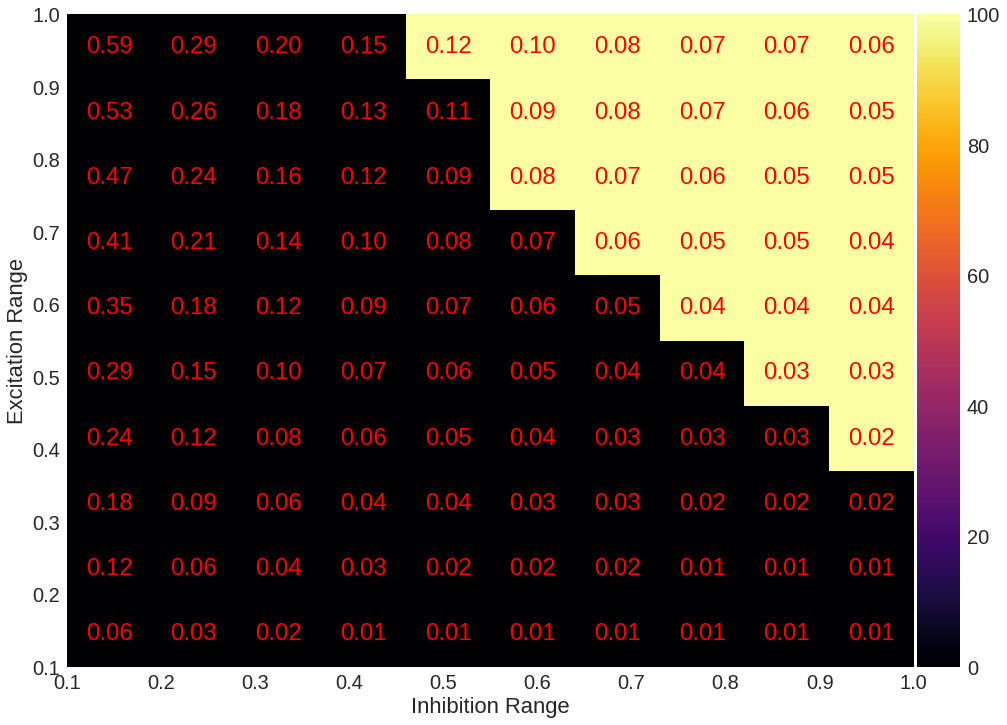

In [96]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)

cmap = 'inferno'

extent = [inhibition_range[0], inhibition_range[-1], excitation_range[0], excitation_range[-1]]
im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');


# Add the text

x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibition_range.size
size_y = excitation_range.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = ratios_matrix[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        label = "{:4.2f}".format(label)
        ax1.text(text_x, text_y, label, color='red', ha='center', va='center')

In [97]:
excitation_range_real = np.zeros_like(excitation_range)
for value_index, value in enumerate(excitation_range):
    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                        sequence_decay, dt, BCPNNFast, NetworkManager, ampa, beta)
    excitation_exp, aux, aux = calculate_excitation(manager.nn, sequences)
    excitation_range_real[value_index] = excitation_exp
    


inhibition_range_real = np.zeros_like(inhibition_range)
for inhibition_index, inhibition in enumerate(inhibition_range):
    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                        sequence_decay, dt, BCPNNFast, NetworkManager, ampa, beta)
    inhibition_exp, aux, aux = calculate_inhibition(manager.nn, sequences)
    inhibition_range_real[inhibition_index] = -inhibition_exp

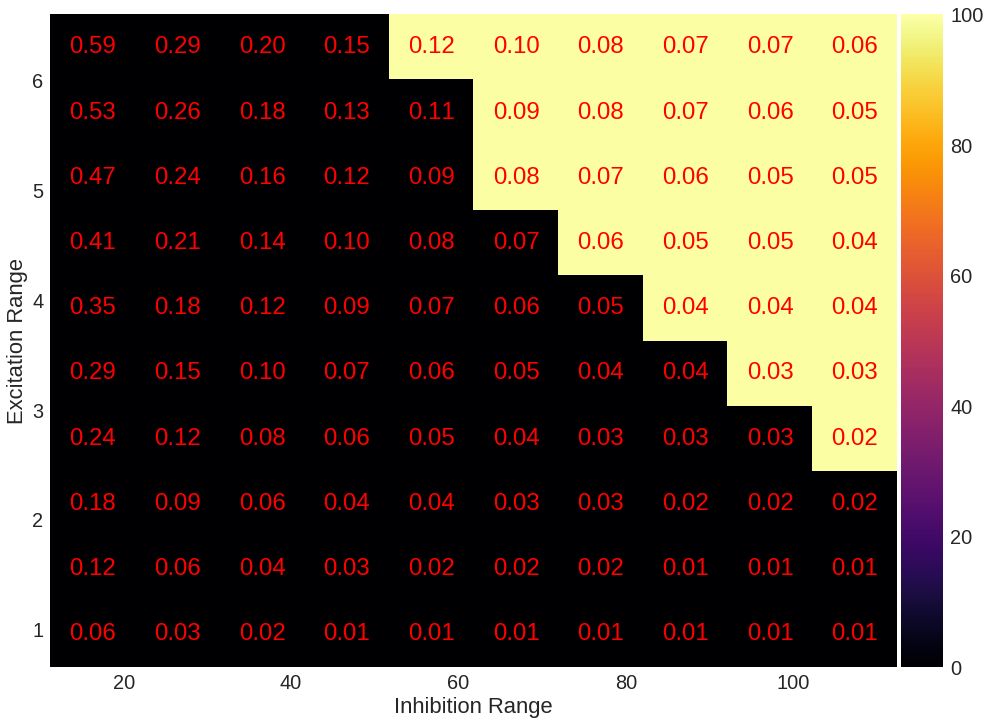

In [101]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)

cmap = 'inferno'

extent = [inhibition_range_real[0], inhibition_range_real[-1], excitation_range_real[0], excitation_range_real[-1]]
im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');


# Add the text

x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibition_range_real.size
size_y = excitation_range_real.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = ratios_matrix[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        label = "{:4.2f}".format(label)
        ax1.text(text_x, text_y, label, color='red', ha='center', va='center')

#### Now we do it with big values

In [102]:
# Patterns parameters
hypercolumns = 4
minicolumns = 30
n_patterns = 10

dt = 0.001


beta = False
value = 3
inhibition = -1.0
extension = 1
decay_factor = 0.5
sequence_decay = 0.0
ampa = True


tau_z_pre = 0.150
g_w = 1.0
g_w_ampa = 1.0
g_a = 97.0

T_recall = 20.0
T_cue = 0.100
n = 1
excitation_range = np.arange(1.0, 33, 3.0)
inhibition_range = np.arange(1.0, 22, 2.0)

sequences = [[i for i in range(n_patterns)]]

In [103]:
success_matrix = np.zeros((excitation_range.size, inhibition_range.size))
ratios_matrix = np.zeros((excitation_range.size, inhibition_range.size))
ratios_matrix_ampa = np.zeros((excitation_range.size, inhibition_range.size))

for value_index, value in enumerate(excitation_range):
    print(value_index)
    for inhibition_index, inhibition in enumerate(inhibition_range):

        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                            sequence_decay, dt, BCPNNFast, NetworkManager, ampa, beta)

        # Calculate success
        success = calculate_recall_success_sequences(manager, T_recall, T_cue, n, sequences)[0]
        success_matrix[value_index, inhibition_index] = success
        
        # Calculate ratio
        ratio, aux, aux = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=False)
        ratios_matrix[value_index, inhibition_index] = ratio
        
        ratio, aux, aux = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratios_matrix_ampa[value_index, inhibition_index] = ratio

0
1
2
3
4
5
6
7
8
9
10


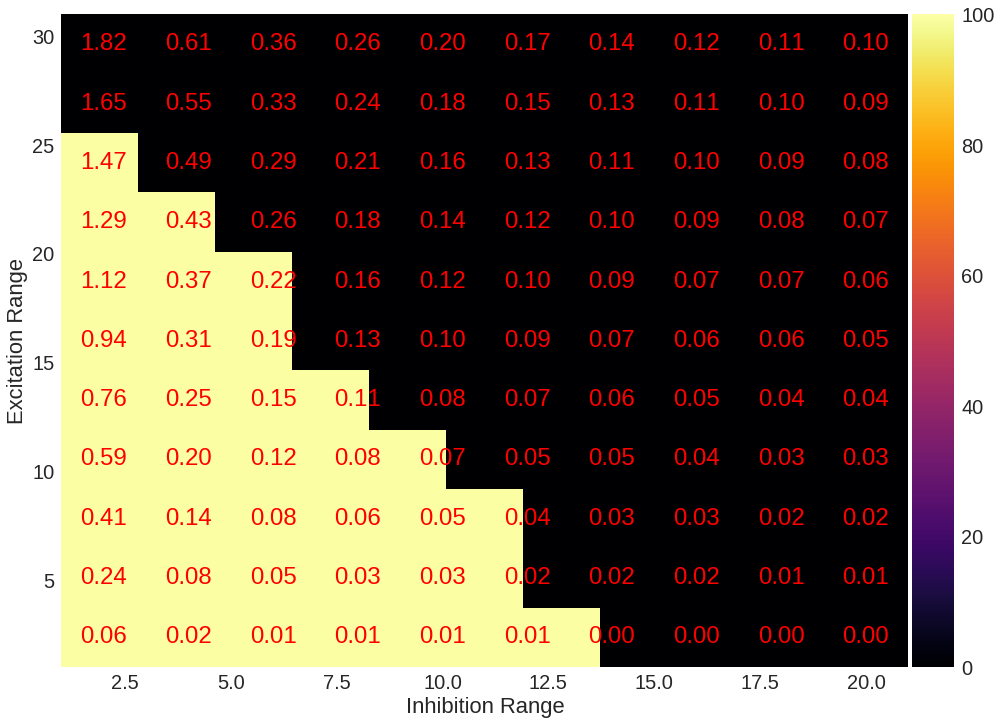

In [104]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)

cmap = 'inferno'

extent = [inhibition_range[0], inhibition_range[-1], excitation_range[0], excitation_range[-1]]
im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');


# Add the text

x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibition_range_real.size
size_y = excitaion_range_real.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = ratios_matrix[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        label = "{:4.2f}".format(label)
        ax1.text(text_x, text_y, label, color='red', ha='center', va='center')

In [75]:
excitation_range_real = np.zeros_like(excitation_range)
for value_index, value in enumerate(excitation_range):
    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                        sequence_decay, dt, BCPNNFast, NetworkManager, ampa, beta)
    excitation_exp, aux, aux = calculate_excitation(manager.nn, sequences)
    excitation_range_real[value_index] = excitation_exp
    


inhibition_range_real = np.zeros_like(inhibition_range)
for inhibition_index, inhibition in enumerate(inhibition_range):
    manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                        sequence_decay, dt, BCPNNFast, NetworkManager, ampa, beta)
    inhibition_exp, aux, aux = calculate_inhibition(manager.nn, sequences)
    inhibition_range_real[inhibition_index] = -inhibition_exp

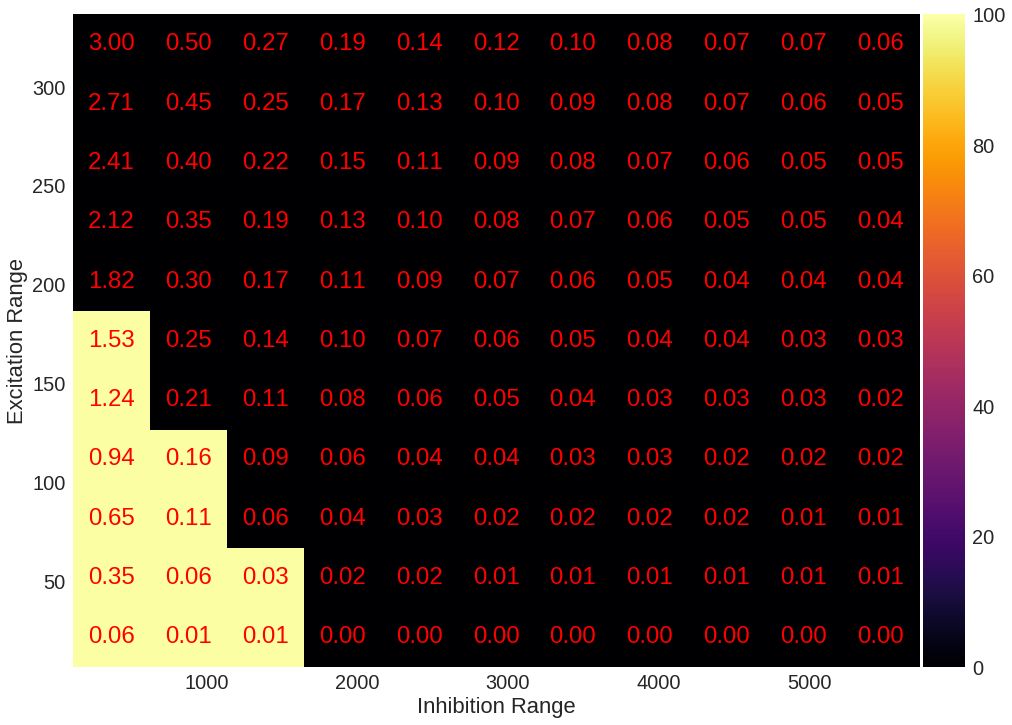

In [77]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)

cmap = 'inferno'

extent = [inhibition_range_real[0], inhibition_range_real[-1], excitation_range_real[0], excitation_range_real[-1]]
im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');


# Add the text

x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibition_range_real.size
size_y = excitaion_range_real.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = ratios_matrix[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        label = "{:4.2f}".format(label)
        ax1.text(text_x, text_y, label, color='red', ha='center', va='center')

#### Double plots

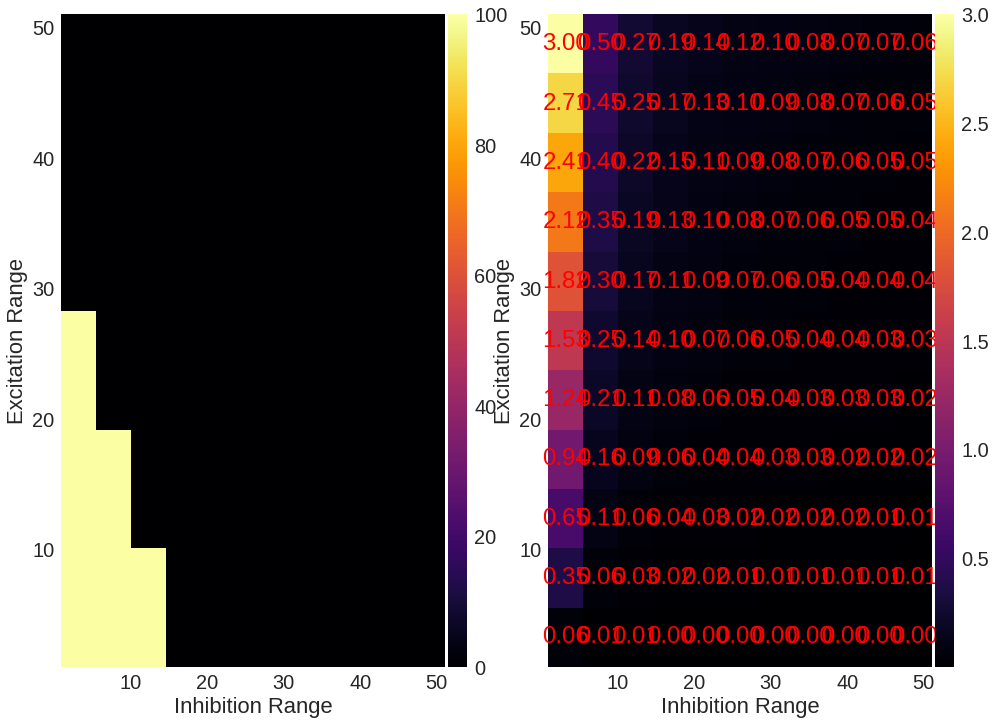

In [78]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cmap = 'inferno'

extent = [inhibition_range[0], inhibition_range[-1], excitation_range[0], excitation_range[-1]]
im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');

im2 = ax2.imshow(ratios_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im2 = ax2.imshow(ratios_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax2.set_xlabel('Inhibition Range')
ax2.set_ylabel('Excitation Range')

ax2.grid()

# Add the text

x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibition_range_real.size
size_y = excitaion_range_real.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = ratios_matrix[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        label = "{:4.2f}".format(label)
        ax2.text(text_x, text_y, label, color='red', ha='center', va='center')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical');

#### Let's plot with the actual excitation per cell

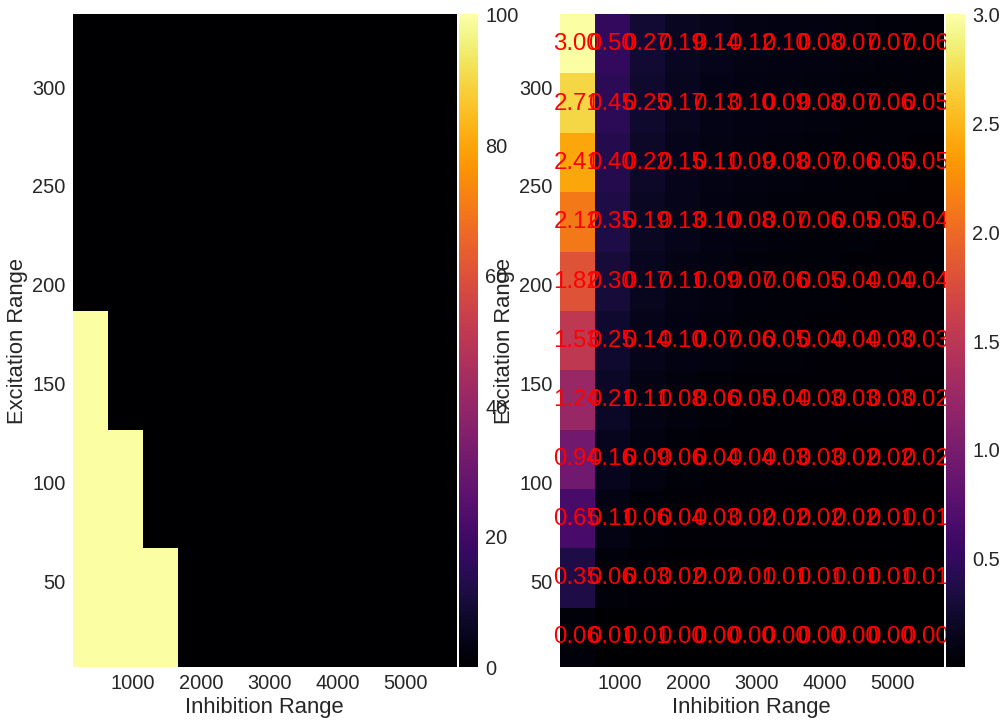

In [79]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cmap = 'inferno'

extent = [inhibition_range_real[0], inhibition_range_real[-1], excitation_range_real[0], excitation_range_real[-1]]
im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');

im2 = ax2.imshow(ratios_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im2 = ax2.imshow(ratios_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax2.set_xlabel('Inhibition Range')
ax2.set_ylabel('Excitation Range')

ax2.grid()

# Add the text

x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibition_range_real.size
size_y = excitaion_range_real.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = ratios_matrix[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        label = "{:4.2f}".format(label)
        ax2.text(text_x, text_y, label, color='red', ha='center', va='center')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical');

## Recall timings

In [5]:
# Patterns parameters
hypercolumns = 4
minicolumns = 30
n_patterns = 10

dt = 0.001


beta = False
value = 3
inhibition = -1.0
extension = 1
decay_factor = 0.5
sequence_decay = 0.0
ampa = True


tau_z_pre = 0.150
g_w = 1.0
g_w_ampa = 1.0
g_a = 97.0

T_recall = 20.0
T_cue = 0.100
n = 1
excitation_range = np.arange(0.1, 1.1, 0.1)
inhibition_range = np.arange(0.1, 1.1, 0.1)

sequences = [[i for i in range(n_patterns)]]

In [8]:
success_matrix = np.zeros((excitation_range.size, inhibition_range.size))
total_time_matrix = np.zeros((excitation_range.size, inhibition_range.size))
mean_time_matrix = np.zeros((excitation_range.size, inhibition_range.size))

ratios_matrix = np.zeros((excitation_range.size, inhibition_range.size))
ratios_matrix_ampa = np.zeros((excitation_range.size, inhibition_range.size))


for value_index, value in enumerate(excitation_range):
    print(value_index)
    for inhibition_index, inhibition in enumerate(inhibition_range):

        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                            sequence_decay, dt, BCPNNFast, NetworkManager, ampa, beta)

        # Calculate success and timings
        total_sequence_time, mean, std, success = calculate_recall_time_quantities(manager, T_recall,
                                                                           T_cue, n, sequences)
        success_matrix[value_index, inhibition_index] = success
        total_time_matrix[value_index, inhibition_index] = total_sequence_time
        mean_time_matrix[value_index, inhibition_index] = mean
        
        # Calculate ratio
        ratio, aux, aux = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=False)
        ratios_matrix[value_index, inhibition_index] = ratio
        
        ratio, aux, aux = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratios_matrix_ampa[value_index, inhibition_index] = ratio

0
1
2
3
4
5
6
7
8
9


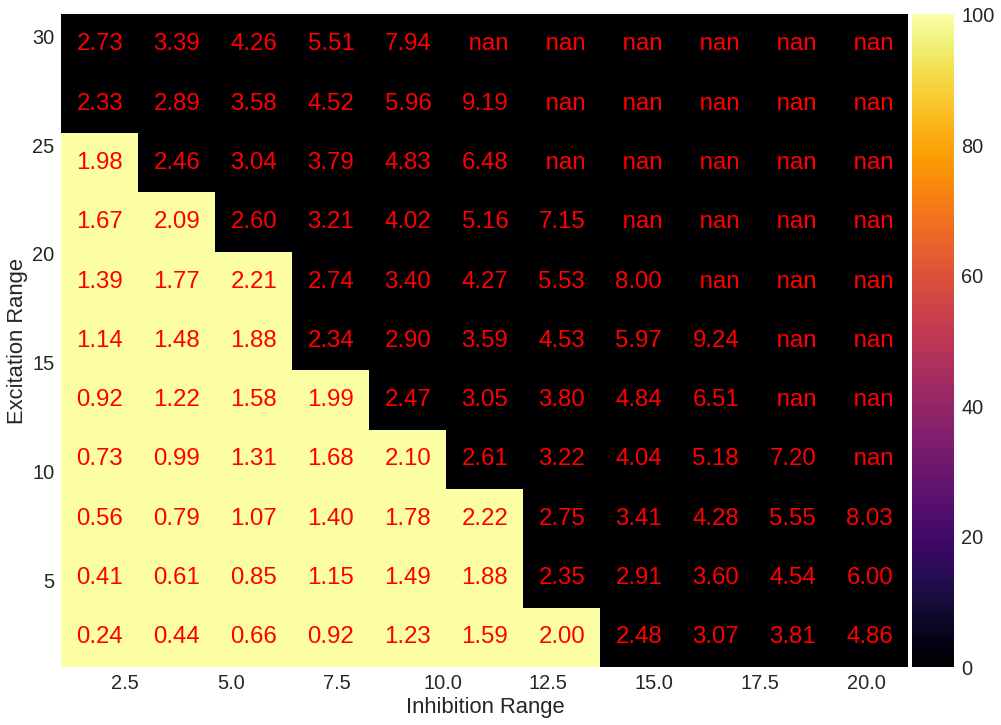

In [22]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)

cmap = 'inferno'

extent = [inhibition_range[0], inhibition_range[-1], excitation_range[0], excitation_range[-1]]
im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');


# Add the text

x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibition_range.size
size_y = excitation_range.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = mean_time_matrix[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        label = "{:4.2f}".format(label)
        ax1.text(text_x, text_y, label, color='red', ha='center', va='center')

In [18]:
# Patterns parameters
hypercolumns = 4
minicolumns = 30
n_patterns = 10

dt = 0.001


beta = False
value = 3
inhibition = -1.0
extension = 1
decay_factor = 0.5
sequence_decay = 0.0
ampa = True


tau_z_pre = 0.150
g_w = 1.0
g_w_ampa = 1.0
g_a = 97.0

T_recall = 20.0
T_cue = 0.100
n = 1
excitation_range = np.arange(1.0, 33, 3.0)
inhibition_range = np.arange(1.0, 22, 2.0)

sequences = [[i for i in range(n_patterns)]]

In [19]:
success_matrix = np.zeros((excitation_range.size, inhibition_range.size))
total_time_matrix = np.zeros((excitation_range.size, inhibition_range.size))
mean_time_matrix = np.zeros((excitation_range.size, inhibition_range.size))

ratios_matrix = np.zeros((excitation_range.size, inhibition_range.size))
ratios_matrix_ampa = np.zeros((excitation_range.size, inhibition_range.size))


for value_index, value in enumerate(excitation_range):
    print(value_index)
    for inhibition_index, inhibition in enumerate(inhibition_range):

        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, -inhibition, extension, decay_factor,
                                            sequence_decay, dt, BCPNNFast, NetworkManager, ampa, beta)

        # Calculate success and timings
        total_sequence_time, mean, std, success = calculate_recall_time_quantities(manager, T_recall,
                                                                           T_cue, n, sequences)
        success_matrix[value_index, inhibition_index] = success
        total_time_matrix[value_index, inhibition_index] = total_sequence_time
        mean_time_matrix[value_index, inhibition_index] = mean
        
        # Calculate ratio
        ratio, aux, aux = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=False)
        ratios_matrix[value_index, inhibition_index] = ratio
        
        ratio, aux, aux = calculate_excitation_inhibition_ratio(manager.nn, sequences, ampa=True)
        ratios_matrix_ampa[value_index, inhibition_index] = ratio

0
1
2
3


/home/heberto/miniconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heberto/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/heberto/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/heberto/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/heberto/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4
5
6
7
8
9
10


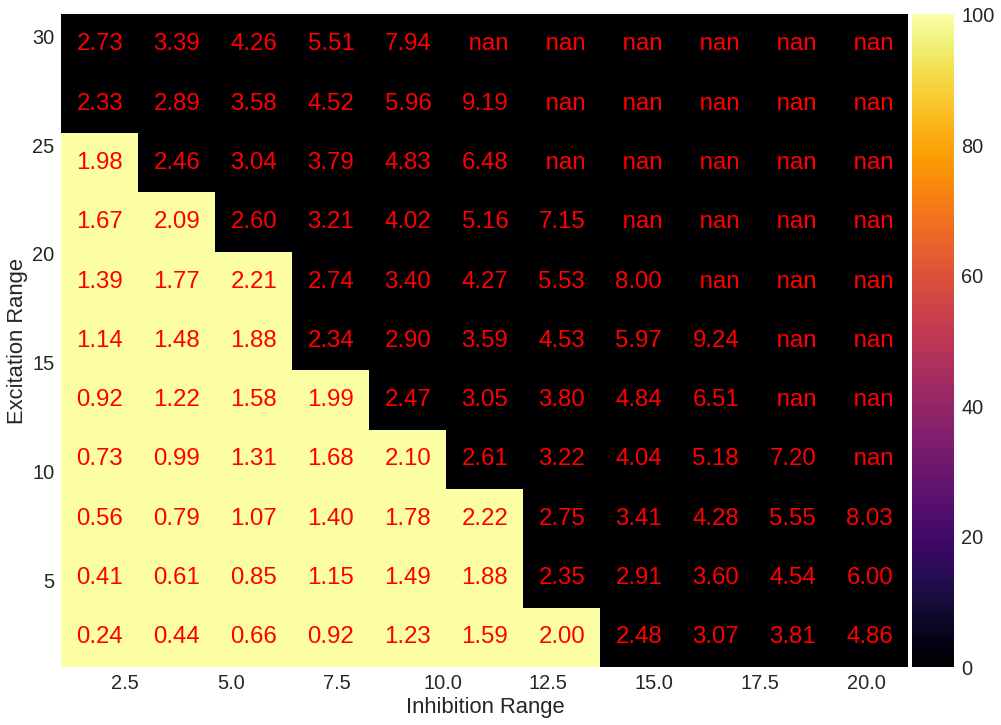

In [21]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)

cmap = 'inferno'

extent = [inhibition_range[0], inhibition_range[-1], excitation_range[0], excitation_range[-1]]
im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', extent=extent, aspect='auto')
# im1 = ax1.imshow(success_matrix, origin='lower', cmap=cmap, interpolation='None', aspect='auto')

ax1.set_xlabel('Inhibition Range')
ax1.set_ylabel('Excitation Range')

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical');


# Add the text

x_start = extent[0]
x_end = extent[1]
y_start = extent[2]
y_end = extent[3]

size_x = inhibition_range.size
size_y = excitation_range.size


jump_x = (x_end - x_start) / (2.0 * size_x)
jump_y = (y_end - y_start) / (2.0 * size_y)
x_positions = np.linspace(start=x_start, stop=x_end, num=size_x, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size_y, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = mean_time_matrix[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        label = "{:4.2f}".format(label)
        ax1.text(text_x, text_y, label, color='red', ha='center', va='center')

#### Git machinery

In [ ]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])